# Inference

In [1]:
import os
import json
import torch
import argparse

from model_cvae import SentenceVAE
from utils import to_var, idx2word, interpolate, AttributeDict

In [2]:
model_dict = {
    'cvae_bowloss': './bin/2019-Dec-01-08:47:43/E9.pytorch',
    'cvae_latent200': './bin/2019-Dec-01-10:27:08/E9.pytorch',
    'cvae_bowloss_latent200': './bin/2019-Dec-01-10:25:05/E9.pytorch',
}

In [3]:
args = {
    'num_samples': 10,
    'max_sequence_length': 50,
    'embedding_size': 300,
    'rnn_type': 'gru',
    'hidden_size': 256,
    'word_dropout': 0,
    'embedding_dropout': 0.5,
    'num_layers': 1,
    'bidirectional': False
}
args = AttributeDict(args)
args.rnn_type = args.rnn_type.lower()
assert args.rnn_type in ['rnn', 'lstm', 'gru']
assert 0 <= args.word_dropout <= 1

## utils

In [4]:
def to_tensor(arr_like, cuda=True):
    tensor = torch.Tensor(arr_like)
    return tensor if not cuda else tensor.cuda()

## load vocab

In [5]:
with open('./data/eccos/src/ptb.vocab.json', 'r') as file:
        src_vocab = json.load(file)
src_w2i, src_i2w = src_vocab['w2i'], src_vocab['i2w']

In [6]:
with open('./data/eccos/tgt/ptb.vocab.json', 'r') as file:
        tgt_vocab = json.load(file)
tgt_w2i, tgt_i2w = tgt_vocab['w2i'], tgt_vocab['i2w']

In [7]:
len(src_w2i), len(tgt_w2i)

(5619, 12106)

In [8]:
# args.obj['cond_embedding_size'] = 300
# args.obj['cond_hidden_size'] = 256

## load model

In [9]:
from ptb import SOS_INDEX, EOS_INDEX, PAD_INDEX, UNK_INDEX

In [10]:
def load_model(path):
    _dict = torch.load(path)
    model_shapes = {k: v.shape for k,v in _dict.items()}
    ext_kwargs = {}
    
    # BOW Loss
    bow_hidden_shape = model_shapes.get('latent2bow.0.weight')
    use_bow_loss = bow_hidden_shape is not None
    print(f'BOW Loss: {use_bow_loss}')
    if use_bow_loss:
        print(f'bow_hidden_size: {bow_hidden_shape[0]}')
        ext_kwargs['bow_hidden_size'] = bow_hidden_shape[0]
    else:
        ext_kwargs['use_bow_loss'] = False
    
    # Latent size
    latent_size = model_shapes.get('hidden2logv.bias')[0]
    print(f'Latent size: {latent_size}')
    
    model = SentenceVAE(
        vocab_size=len(tgt_w2i),
        sos_idx=SOS_INDEX,
        eos_idx=EOS_INDEX,
        pad_idx=PAD_INDEX,
        unk_idx=UNK_INDEX,
        max_sequence_length=args.max_sequence_length,
        embedding_size=args.embedding_size,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        latent_size=latent_size,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,

        # condional
        cond_vocab_size=len(src_w2i), 
        cond_embedding_size=args.embedding_size,
        cond_hidden_size=256,
        
        **ext_kwargs,
    )
    
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    model.load_state_dict(torch.load(path))
    print("Model loaded from %s"%(path))

    if torch.cuda.is_available():
        model = model.cuda()
        
    model.eval()
    return model

## sample 指定 inference

### load test data

In [11]:
from ptb import PTB
test_src_ptb = PTB(
    data_dir='./data/eccos/src/',
    split='test',
    create_data=False,
)

In [12]:
test_src_ptb

In [13]:
# 実際のデータ確認用
def ids2text(id_list, ptb, sep=''):
    return sep.join([ptb.i2w[f'{i}'] for i in id_list])

In [14]:
def words2ids(words, ptb):
    assert type(words) == list
    return [test_src_ptb.w2i.get(word, UNK_INDEX) for word in words]

def words2sample(words, ptb):
    id_list = [SOS_INDEX] + words2ids(words, ptb)
    sample = {'input': id_list, 'length': len(id_list)}
    return sample

In [15]:
# データをピックアップ, 確認
sample = words2sample('ランキング 化粧品 人気'.split(), test_src_ptb)
# sample = test_src_ptb.data['240']
print(f'▼ Input length:{sample["length"]}\n{ids2text(sample["input"], test_src_ptb, " ")}')
sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)

▼ Input length:4
<sos> ランキング 化粧品 人気


### sampling

In [16]:
def encode_condition(model, sample_input, sample_length):
    # 潜在変数zの取得 condition
    cond_hidden, cond_mean, cond_logv, cond_z = model.encode_condition(sample_input, sample_length)
    dec_input = torch.cat([cond_z, cond_hidden], dim=1)
    return dec_input

In [17]:
def encode_print_samples(model, sample_input, sample_length, n=30):
    # n回サンプリング
    args.num_samples = n
    dec_input = torch.cat([encode_condition(model, sample_input, sample_length) for _ in range(args.num_samples)])
    samples, _ = model.inference(z=dec_input)
    print('■ 入力')
    print(*idx2word(torch.Tensor(sample['input']).int().view(1, -1), i2w=src_i2w, pad_idx=PAD_INDEX), sep='\n')
    print(f'■ {args.num_samples}件 サンプリング')
    print(*[s.replace('<eos>', '').replace(' ', '') for s in idx2word(samples, i2w=tgt_i2w, pad_idx=PAD_INDEX)], sep='\n')

In [18]:
model_dict

{'cvae_bowloss': './bin/2019-Dec-01-08:47:43/E9.pytorch',
 'cvae_latent200': './bin/2019-Dec-01-10:27:08/E9.pytorch',
 'cvae_bowloss_latent200': './bin/2019-Dec-01-10:25:05/E9.pytorch'}

In [19]:
# model = load_model(model_dict['cvae_bowloss'])
model = load_model(model_dict['cvae_bowloss_latent200'])

BOW Loss: True
bow_hidden_size: 256
Latent size: 200
Model loaded from ./bin/2019-Dec-01-10:25:05/E9.pytorch


In [20]:
encode_print_samples(model, sample_input, sample_length, 30)

■ 入力
<sos> ランキング 化粧品 人気
■ 30件 サンプリング
本当に人気ランキング<num>位を紹介♪優秀人気化粧品【口コミ】
化粧品の種類で人気コスメがリニューアル!オーガニック商品【<unk>】
人気化粧品の化粧品で揃う?化粧品の<unk>だけじゃない、優秀な「<unk>」を✓
化粧品の人気コスメセット【ティント】<num>本!絶対に買うべき!
ランキング人気の化粧品たちがこぞって登場!
【優しい】ヴォリュプテティントインバーム化粧品「化粧品」|人気の<num>年版
人気化粧品の人気シングルアイカラー【化粧品/<person>一覧】
化粧品ランキング(化粧品)人気だった!これ一つの口コミが続々なる♪
人気の化粧品ランキング&人気コスメがインスタ!人気では人気の<unk>
化粧品通【<person>】人気の化粧品がセットで使える<person>
人気化粧品の化粧品ランキング【価格・美容】イスラエル<num>選
[人気化粧品】<num>年の「植物化粧品」がめちゃお手軽に集結
人気化粧品の方法がこぞってリニューアルした!<unk>に癒されるヘレナルビンスタインがすごい
人気化粧品ブランドの<unk>コスメまとめ(゚)まとめ
人気化粧品の人気コスメまとめ
人気化粧品の<unk>ランキングをプレゼントに使える固形ランキング♡キャンメイクのお手入れブランドがおすすめブランド
人気ランキングランキングの使い方<num>品
化粧品別化粧水!人気の基礎化粧品も嬉しい
人気化粧品に<unk>!人気のコスメが続々登場する女性用<num>選
人気リップのクレンジングランキング|<person>でも安心
ランキング人気ランキング!人気沸騰中の方法をご紹介します♡
化粧品化粧品【メイベリン】化粧品のオーガニックアイテムがカギ【<person>】<num>年版
人気インスタグラマーの人気ブランド<num>年連続「<unk>」は、<person>の使い方!
【ランキング発!】<person>たちが使ってる♡感動の優秀コスメはコレ
化粧品ブランドの「<unk>」に人気方法まとめ。<num>種類は「<unk>」が販売開始います♡
【化粧品】の人気化粧品で<num>年秋冬の栄養さ
化粧品ランキング!人気化粧品のメリットが本当に使えるアイテムを徹底解剖
化粧品業界・ランキング!口コミで人気

## 潜在空間のプロット
圧縮して分布を確認してみる

In [21]:
import umap.umap_ as umap

In [22]:
# 描画用
# https://github.com/lmcinnes/umap/blob/master/notebooks/UMAP%20usage%20and%20parameters.ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})
def plot_scatter(u, title=''):
    fig = plt.figure()
    n_components = u.shape[1]
    plot_kwargs = {'alpha': 0.5, 's':5}
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), **plot_kwargs)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], **plot_kwargs)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d', **plot_kwargs)
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

### load test data

In [23]:
from ptb import PTB
test_ptb = PTB(
    data_dir='./data/eccos/src/',
    split='test',
    create_data=False,
)

In [24]:
def sample_to_tensor(sample):
    sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)
    return sample_input, sample_length

In [25]:
%%time
# テストデータを潜在変数に変換
with torch.no_grad():
    # encoded_samples = [model.encode(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
    encoded_samples = [model.encode_condition(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
    encoded_mean_list = [cond_mean.tolist() for cond_hidden, cond_mean, cond_logv, cond_z in encoded_samples]

CPU times: user 12.3 s, sys: 361 ms, total: 12.7 s
Wall time: 12.7 s


In [26]:
encoded_mean_arr = np.array(encoded_mean_list).squeeze()

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
%%time
mean_u = umap.UMAP().fit_transform(encoded_mean_arr)

CPU times: user 37.9 s, sys: 163 ms, total: 38.1 s
Wall time: 37.6 s


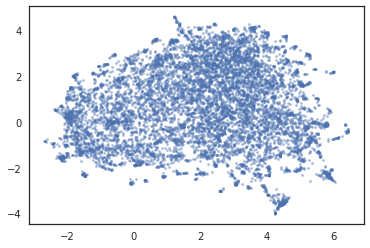

In [29]:
plot_scatter(mean_u)